# Goal: Define task events & associated locations & costs


In [1]:
import os
from pathlib import Path

CURRENT_DIR = Path(os.getcwd())
EXAMPLE_DIR = CURRENT_DIR.parent
HOME_DIR = EXAMPLE_DIR.parent
os.chdir(HOME_DIR)

In [2]:
%load_ext autoreload
%autoreload 2

# additional imports
import numpy as np
from IPython.display import Video

# from tpossp import utils  # TODO: COPY-PASTED from TPO. MUST DELETE OR MERGE INTO TPOSSP
import specless as sl
import matplotlib.pyplot as plt
import gymnasium as gym

from specless.minigrid.aircraftenv import AircraftTurnaroundEnv  # NOQA


CURRENT_DATA_DIR = os.path.join(CURRENT_DIR, "data")
CURRENT_OUTPUT_DIR = os.path.join(CURRENT_DIR, "output")
CURRENT_CONFIG_FILENAME = os.path.join(CURRENT_DIR, "config.json")

LOG_DIR: Path = Path.cwd().joinpath(".log")
print(str(LOG_DIR))

/Users/kandai/Documents/projects/dev/specless/.log


# Load Aircraft Turnaround Data

Got the experiment idea from a paper. See how we generate data in `data.ipynb`

Title: "Causal analysis of aircraft turnaround time for process reliability evaluation and disruptions’ identification"
Paper: https://www.tandfonline.com/doi/full/10.1080/21680566.2017.1325784

Table 2 (Renamed to `ground_services_by_operations.csv`): https://www.tandfonline.com/action/downloadTable?id=T0002&doi=10.1080%2F21680566.2017.1325784&downloadType=CSV
Table 3 (Renamed to `duration.csv`): https://www.tandfonline.com/action/downloadTable?id=T0003&doi=10.1080%2F21680566.2017.1325784&downloadType=CSV


In [3]:
import pickle

filename = os.path.join(CURRENT_DATA_DIR, "demonstrations.pickle")
with open(filename, "rb") as f:
    demonstrations = pickle.load(f)
print(demonstrations[0])

[(1.2586576235728717, 'Start deboarding'), (10.785720792434807, 'Bulk unloading'), (5.646180247034661, 'Toilet servicing'), (3.940719408831283, 'Potable water servicing'), (7.919882523714166, 'Deboarding'), (15.919882523714165, 'PRM arrival servicing'), (31.919882523714165, 'Catering'), (26.591983785955335, 'Cleaning'), (28.5786794135008, 'Refueling'), (44.41613569929914, 'Boarding'), (31.731267174853738, 'PRM departure servicing'), (61.083605366719034, 'Bulk loading'), (62.342028733872354, 'Ready for OB')]


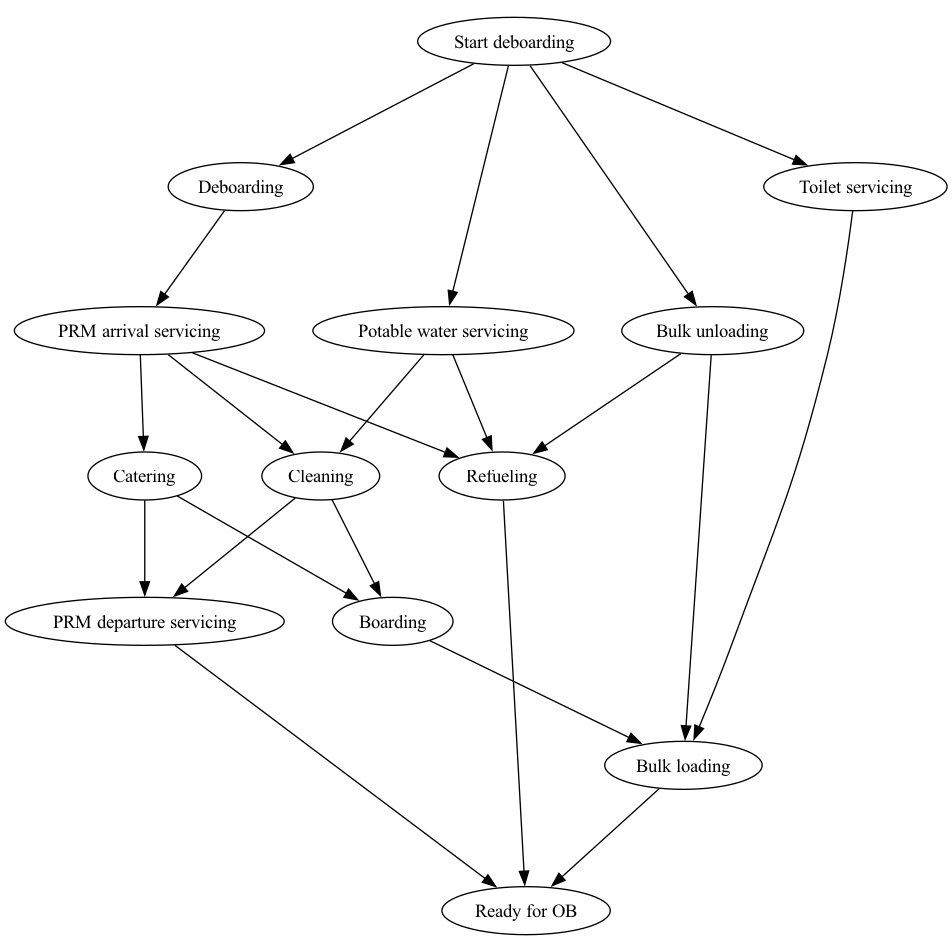

	4.471976594765183 <= t_Catering <= 43.0
	8.458337149954968 <= t_Cleaning <= 44.0
	11.206151206631574 <= t_PRM departure servicing <= 51.0
	0.1103018898733854 <= t_Potable water servicing <= 7.0
	0.0 <= t_Deboarding <= 19.0
	2.1539781622421756 <= t_Refueling <= 44.0
	13.570351939034431 <= t_Boarding <= 65.0
	22.86647701556529 <= t_Ready for OB <= 97.05637549688173
	0.0 <= t_Bulk unloading <= 19.0
	21.63354549193413 <= t_Bulk loading <= 93.99476754797286
	0.0 <= t_Toilet servicing <= 10.0
	0.0 <= t_Start deboarding <= 3.0
	0.0 <= t_PRM arrival servicing <= 27.0
	-0.0 <= t_Bulk unloading - t_Start deboarding <= 16.0
	-0.0 <= t_Toilet servicing - t_Start deboarding <= 7.000000000000001
	-0.0 <= t_Potable water servicing - t_Start deboarding <= 4.0
	-0.0 <= t_Deboarding - t_Start deboarding <= 16.0
	-0.0 <= t_Refueling - t_Bulk unloading <= 40.32061841502289
	4.230321773003119 <= t_Bulk loading - t_Bulk unloading <= 88.74380381435482
	17.67578337316046 <= t_Bulk loading - t_Toilet servicin

In [4]:
inference = sl.TPOInferenceAlgorithm()
specification: sl.Specification = inference.infer(demonstrations)

filepath = os.path.join(LOG_DIR, "tpo.png")
sl.draw_graph(specification, filepath)
print(specification)

In [5]:
env = gym.make("MiniGrid-AircraftTurnaroundEnv-v0", render_mode="rgb_array")
env = sl.OmniDirectionActionWrapper(
    env, sl.EightOmniDirectionActions, sl.EIGHT_ACTION_TO_POS_DELTA
)
env = sl.MiniGridTransitionSystemWrapper(env, ignore_direction=True)

/usr/local/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/usr/local/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.actions` for environment variables or `env.get_wrapper_attr('actions')` that will search the reminding wrappers.
  logger.warn(


In [6]:
from specless.automaton.transition_system import TransitionSystem

tsbuilder = sl.TSBuilder()
minigrid_TS: TransitionSystem = tsbuilder(env)
print(minigrid_TS.observations)

{'', 'box_grey', 'floor_blue', 'box_blue', 'box_red', 'floor_red', 'box_purple', 'lava_red', 'box_green', 'floor_purple', 'floor_green', 'floor_grey'}


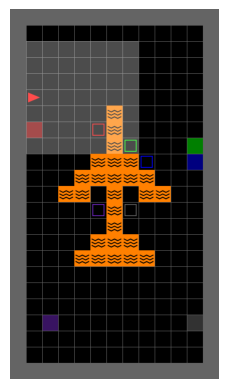

In [7]:
env.reset()
plt.imshow(env.render())
plt.axis("off")
plt.show()

### Associate the name and the obervation label


In [8]:
print(minigrid_TS.observations)
print(specification.nodes)
print(specification.global_constraints)
print(specification.local_constraints)

mapping = {
    "Bulk unloading": "box_purple",
    "Start deboarding": "box_red",
    "Bulk loading": "floor_purple",
    "Boarding": "floor_red",
    "Catering": "box_green",
    "Cleaning": "box_purple",
    "Deboarding": "floor_red",
    "Refueling": "box_blue",
}

relabeled_spec = sl.TimedPartialOrder()
for node, d in specification.global_constraints.items():
    if node not in mapping:
        continue
    relabeled_node = mapping[node]
    relabeled_spec.add_global_constraint(relabeled_node, d["lb"], d["ub"])

for src, edge_dict in specification.local_constraints.items():
    if src not in mapping:
        continue
    for tgt, d in edge_dict.items():
        if tgt not in mapping:
            continue
        relabeled_src = mapping[src]
        relabeled_tgt = mapping[tgt]
        relabeled_spec.add_local_constraint(
            relabeled_src, relabeled_tgt, d["lb"], d["ub"]
        )

{'', 'box_grey', 'floor_blue', 'box_blue', 'box_red', 'floor_red', 'box_purple', 'lava_red', 'box_green', 'floor_purple', 'floor_green', 'floor_grey'}
['Catering', 'Cleaning', 'PRM departure servicing', 'Potable water servicing', 'Deboarding', 'Refueling', 'Boarding', 'Ready for OB', 'Bulk unloading', 'Bulk loading', 'Toilet servicing', 'Start deboarding', 'PRM arrival servicing']
defaultdict(<function TimedPartialOrder.__init__.<locals>.<lambda> at 0x111d879c0>, {'Catering': {'lb': 4.471976594765183, 'ub': 43.0}, 'Cleaning': {'lb': 8.458337149954968, 'ub': 44.0}, 'PRM departure servicing': {'lb': 11.206151206631574, 'ub': 51.0}, 'Potable water servicing': {'lb': 0.1103018898733854, 'ub': 7.0}, 'Deboarding': {'lb': 0.0, 'ub': 19.0}, 'Refueling': {'lb': 2.1539781622421756, 'ub': 44.0}, 'Boarding': {'lb': 13.570351939034431, 'ub': 65.0}, 'Ready for OB': {'lb': 22.86647701556529, 'ub': 97.05637549688173}, 'Bulk unloading': {'lb': 0.0, 'ub': 19.0}, 'Bulk loading': {'lb': 21.63354549193413,

In [9]:
import pandas as pd

filename = os.path.join(CURRENT_DATA_DIR, "my_experiment_setup2.csv")
df = pd.read_csv(filename)
df

,No.,Activity,ServiceTime,Service,From,To,Precedence,Operation
0,1,Arrival,0,Uncontrollable,NaN,NaN,,Start Deboarding
1,2,PlaceStairs,0,Move,floor_red,box_red,1,Start Deboarding
2,3,Deboarding,25,Uncontrollable,box_red,floor_red,2,Deboarding
3,4,PlaceCateringVehicle,0,Move,floor_purple,box_purple,1,Catering
4,5,StartCatering,10,Stay,box_purple,box_purple,"3,4",Catering
5,6,MoveOutCateringVehicle,0,Move,box_purple,floor_purple,5,Catering
6,7,PlaceAndStartRefueling,0,Move,floor_blue,box_blue,1,Refueling
7,8,Refueling,15,Uncontrollable,box_blue,box_blue,7,Refueling
8,9,EndAndMoveOutRefueling,0,Move,box_blue,floor_blue,8,Refueling
9,10,PlaceConveyerVehicle,0,Move,floor_grey,box_grey,1,Bulk Unloading


In [11]:
from bidict import bidict

# Inputs to TSP Builder (T, specification, initial_states, services):
# 1. Initial States
# 2. ServiceTPO (From & To locations must match with observations in T)
# 3. Services

initial_locations = [(2, 2), (2, 18), (10, 10)]
initial_locations = [(10, 10)]
services = sl.ServiceTimedPartialOrder.load_services(filename)

In [14]:
synthesizer = sl.ServiceTSPSynthesisAlgorithm()
strategy = synthesizer.synthesize(env, specification, num_agent=1, services=services)
print(strategy)

/usr/local/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.actions` for environment variables or `env.get_wrapper_attr('actions')` that will search the reminding wrappers.
  logger.warn(


NameError: name 'AircraftTurnaroundTSPBuilder' is not defined

In [13]:
for i, s in enumerate(strategy.strategies):
    states, actions, video_path = sl.simulate(
        env,
        s,
        record_video=True,
        video_folder=os.path.join(LOG_DIR, str(i)),
    )

    Video(video_path, embed=True, html_attributes="controls muted autoplay loop")

NameError: name 'strategy' is not defined

In [ ]:
# Now, given a tour, times, and a converter, come up with a waypoints w/ timeouts

tour_ = tours[0]
# Compute the control inputs
controls, trace = ts_converter.to_controls(tour_, times)
print(
    "Controls: ",
    len(controls),
    controls,
)
print("Trace", len(trace), trace)
# Set the Initial State
s = ts_converter.service_to_node.inverse[tour_[0]]
minigrid_TS.start_state = ts_converter.service_position_label_to_state(s.from_str)
# Simulate
output_string, visited_states, video_path = minigrid_TS.run(controls, record_video=True)
locations = [ts_converter.state_to_location(s) for s in visited_states]
# Print out
services = [ts_converter.service_to_node.inverse[n] for n in tour_]
service_names = [s.name for s in services]
print("Tour: ", tour_)
print("Services: ", service_names)
print("Visited States: ", visited_states)
print("Locations: ", locations)
print("Saved to ", video_path)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")

In [ ]:
tour_ = tours[2]
# Compute the control inputs
controls, trace = ts_converter.to_controls(tour_, times)
print(
    "Controls: ",
    len(controls),
    controls,
)
print("Trace", len(trace), trace)
# Set the Initial State
s = ts_converter.service_to_node.inverse[tour_[0]]
minigrid_TS.start_state = ts_converter.service_position_label_to_state(s.from_str)
# Simulate
output_string, visited_states, video_path = minigrid_TS.run(controls, record_video=True)
locations = [ts_converter.state_to_location(s) for s in visited_states]
# Print out
services = [ts_converter.service_to_node.inverse[n] for n in tour_]
service_names = [s.name for s in services]
print("Tour: ", tour_)
print("Services: ", service_names)
print("Visited States: ", visited_states)
print("Locations: ", locations)
print("Saved to ", video_path)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")

In [ ]:
tour_ = tours[3]
# Compute the control inputs
controls, trace = ts_converter.to_controls(tour_, times)
print(
    "Controls: ",
    len(controls),
    controls,
)
print("Trace", len(trace), trace)
# Set the Initial State
s = ts_converter.service_to_node.inverse[tour_[0]]
minigrid_TS.start_state = ts_converter.service_position_label_to_state(s.from_str)
# Simulate
output_string, visited_states, video_path = minigrid_TS.run(controls, record_video=True)
locations = [ts_converter.state_to_location(s) for s in visited_states]
# Print out
services = [ts_converter.service_to_node.inverse[n] for n in tour_]
service_names = [s.name for s in services]
print("Tour: ", tour_)
print("Services: ", service_names)
print("Visited States: ", visited_states)
print("Locations: ", locations)
print("Saved to ", video_path)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")